In [2]:
! [ -e /content ] && pip install -Uqq fastbook
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 67.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 65.5 MB/s eta 0:00:0000:0100:01
^C
ERROR: Operation cancelled by user


In [4]:
from fastai.vision.all import *
from fastbook import *
torch.cuda.is_available()

True

In [5]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
path.ls()
(path/'images').ls()
fname = (path/'images').ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['miniature_pinscher']

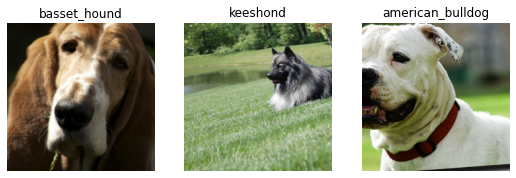

In [6]:


pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = pets.dataloaders(path/'images')
dls.show_batch(nrows=1, ncols=3)


In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.472687,0.365261,0.123816,01:24


epoch,train_loss,valid_loss,error_rate,time
0,0.510646,0.332976,0.089310,01:51
1,0.354833,0.268394,0.083897,01:51


In [12]:
x,y = dls.one_batch()
y

TensorCategory([13, 11, 28, 36, 36, 30, 24, 29, 33, 14, 24, 31, 22, 18, 22, 21, 18,  8, 22, 31,  2, 32,  3, 23, 31, 35, 26,  5, 13, 35, 11, 36,  0, 16, 14,  6, 31, 24,  7, 22, 28, 21, 31,  5, 23, 33, 17, 35,
        11, 20, 30, 19,  5, 35, 31, 17, 15,  0,  5,  3,  5, 20, 34,  2], device='cuda:0')

In [13]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [14]:
torch.random.manual_seed(42)
acts = torch.randn((6,2))*2 # *2 creates a stdev of 2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [18]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [19]:
# Log Likelhood loss

targs = tensor([0,1,0,1,1,0])
idx = range(6)
sm_acts[idx, targs]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [26]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

/tmp/ipykernel_62/2201212877.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  t = df.style.hide_index()


3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


In [24]:
-sm_acts[idx, targs]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [25]:
# Negative Log Likelihood loss
F.nll_loss(sm_acts, targs, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
loss_func = nn.CrossEntropyLoss(reduction = 'none') # reduction = 'none' prevents taking the mean 
loss_func(acts, targs)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

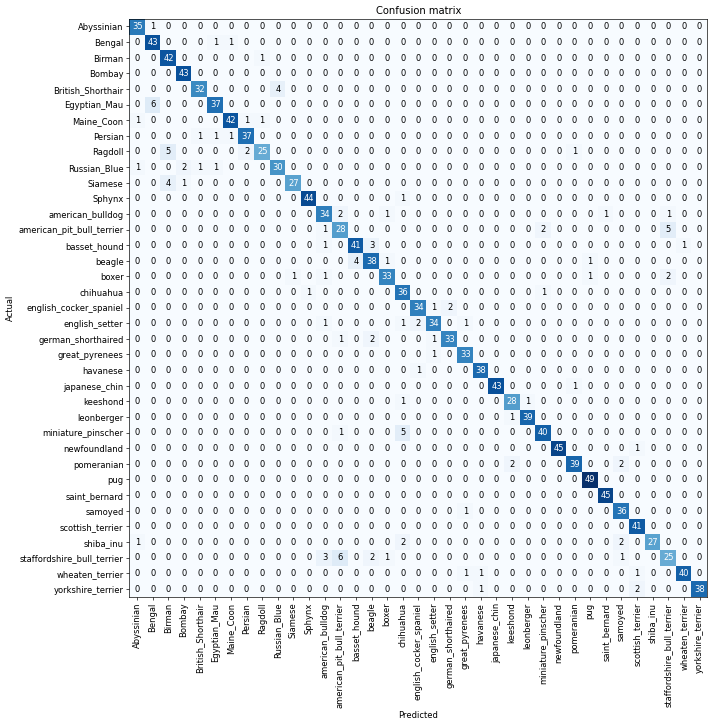

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('miniature_pinscher', 'chihuahua', 5)]

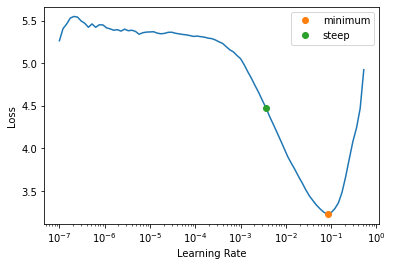

In [33]:
# Learning Rate Finder
learn = vision_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [35]:
# The fastest learning rate is 3.63e-03 so lets use that for learning
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 3.63e-03


In [37]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.306588,0.332830,0.103518,01:24


epoch,train_loss,valid_loss,error_rate,time
0,0.535546,0.389299,0.117727,01:51
1,0.318411,0.235427,0.076455,01:51


In [38]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3) # fit_one_cycle() learns with frozen layers

epoch,train_loss,valid_loss,error_rate,time
0,1.125153,0.412335,0.125169,01:24
1,0.527990,0.250850,0.081191,01:24
2,0.328177,0.222387,0.072395,01:24


SuggestedLRs(valley=3.630780702224001e-05)

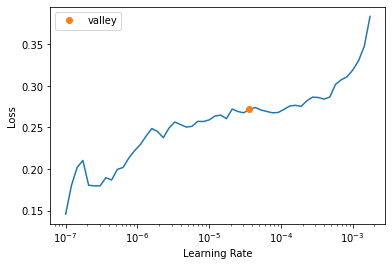

In [39]:
learn.unfreeze()
learn.lr_find()
# Note: this is a pretrained model so we do not see the steep drop in loss. 
# We want to ensure we do not choose a learning rate that will result in loss increase,
# so we want to choose a learning rate well before the steep incline in loss

In [42]:
learn.fit_one_cycle(6, lr_max=3.63e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.237541,0.215746,0.063599,01:50
1,0.240523,0.217252,0.071719,01:51
2,0.210925,0.207729,0.066306,01:51
3,0.170091,0.191136,0.057510,01:51
4,0.137408,0.184856,0.056157,01:51
5,0.113091,0.183232,0.057510,01:51


In [43]:
# Discrimative Learning Rates (pass lr as slice) The middle layers' lr will be fall on the line
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.191203,0.335749,0.103518,01:25
1,0.534332,0.253891,0.075778,01:23
2,0.321145,0.230955,0.071042,01:24


epoch,train_loss,valid_loss,error_rate,time
0,0.261639,0.222245,0.071042,01:51
1,0.254595,0.217156,0.066982,01:51
2,0.243932,0.209871,0.069012,01:51
3,0.221491,0.197252,0.062923,01:51
4,0.195518,0.208853,0.066306,01:51
5,0.174145,0.202771,0.063599,01:51
6,0.165579,0.201022,0.063599,01:51
7,0.156454,0.197821,0.062246,01:51
8,0.140577,0.198452,0.062923,01:51
9,0.136055,0.200291,0.064953,01:51


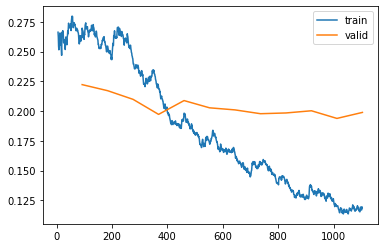

In [45]:
learn.recorder.plot_loss()

In [47]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.274791,0.309540,0.103518,01:46
1,0.594460,0.286560,0.081191,01:47
2,0.429883,0.298986,0.094046,01:47


epoch,train_loss,valid_loss,error_rate,time
0,0.272543,0.278310,0.089986,02:19
1,0.320994,0.378606,0.101489,02:19
2,0.270322,0.297003,0.085927,02:18
3,0.149085,0.240139,0.069689,02:19
4,0.100108,0.205762,0.061570,02:19
5,0.070564,0.203978,0.056834,02:19


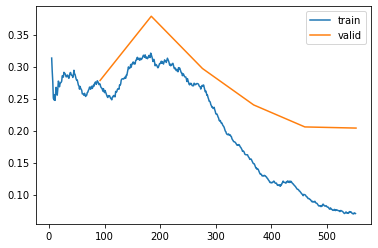

In [49]:
learn.recorder.plot_loss()

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused()

[('Egyptian_Mau', 'Bengal', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('basset_hound', 'beagle', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Ragdoll', 'Birman', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('shiba_inu', 'samoyed', 2),
 ('Abyssinian', 'Bengal', 1),
 ('Abyssinian', 'Maine_Coon', 1),
 ('Bengal', 'Abyssinian', 1),
 ('Maine_Coon', 'Bengal', 1),
 ('Persian', 'Maine_Coon', 1),
 ('Persian', 'Ragdoll', 1),
 ('Persian', 'scottish_terrier', 1),
 ('Russian_Blue', 'Bombay', 1),
 ('Sphynx', 'miniature_pinscher', 1),
 ('american_bulldog', 'boxer', 1),
 ('american_bulldog', 'staffordshire_bull_terrier', 1),
 ('american_pit_bull_ter